# ETT training visualization

In [1]:
import argparse

import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import iplot

from scripts.ett.pretrain import Experiment
from src.litmodules import LitSMCModule
from src.utils import flatten_batches, plot_range, predict, plot_particules_prediction

# Set manual seeds
torch.manual_seed(1)
np.random.seed(1)

# Matplotlib defaults
plt.rcParams.update({
    "font.size": 25,
    "figure.figsize": (14, 7),
    "axes.grid": True,
    "grid.color": "#93a1a1",
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Reload python packages when changed
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
args = argparse.Namespace(
    dataset_path="datasets/ETTh1.csv",
    load_path="checkpoints/ett_finetune/2022_08_26__121922.ckpt",
    finetune=False,
    T=48,
    batch_size=3,
    num_workers=4,
    epochs=3,
    gpus=1,
    logger=False,
)
Experiment.exp_name = "ett_visu"
exp = Experiment(args)
exp.datamodule.setup()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Visualize dataset

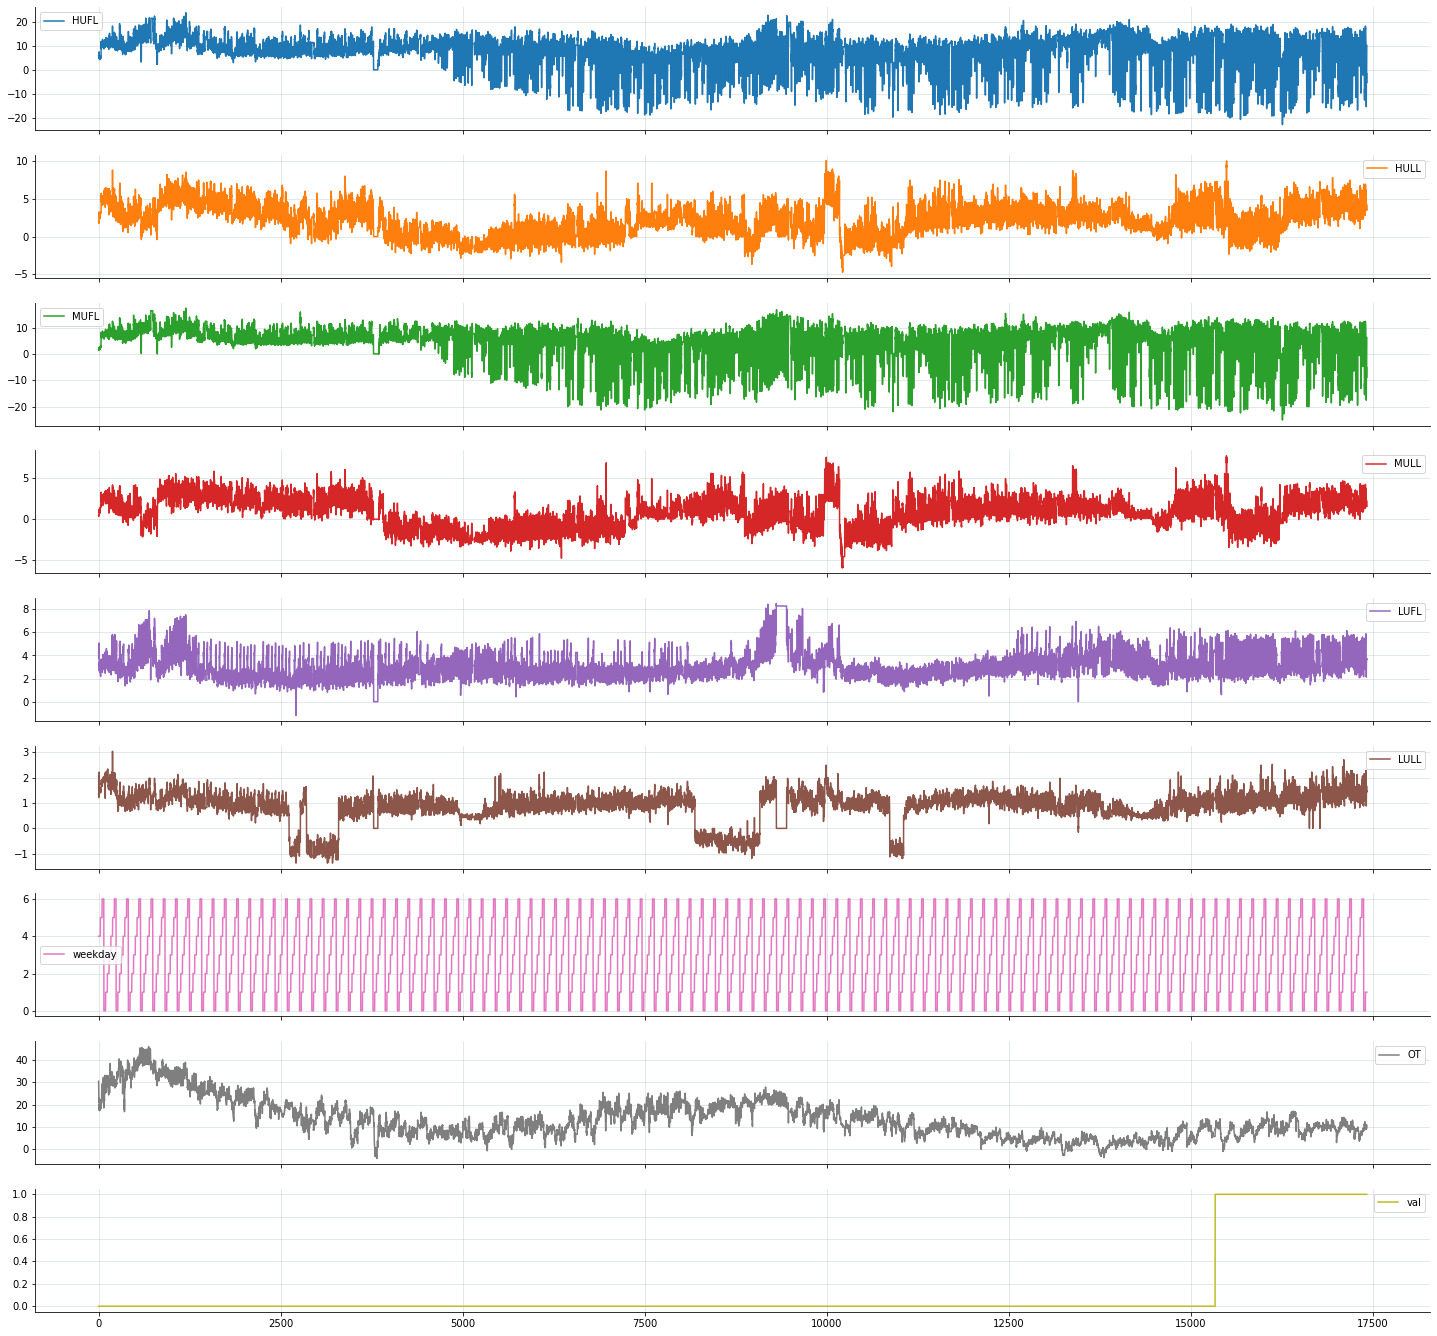

In [3]:
exp.datamodule.visualize()

## Classic evaluations

### Plot the entire dataset

In [4]:
class LitEvalModule(LitSMCModule):
    def validation_step(self, batch, batch_idx):
        u, y = batch
        y_hat = self.forward(u, y)
        loss = self.criteria(y, y_hat)
        self.log("val_loss", loss)
        return y, y_hat
    def validation_epoch_end(self, outputs):
        observations, predictions = map(flatten_batches, zip(*outputs))        
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=observations[:, 0].cpu().numpy().squeeze(), mode="lines", name="observations"))
        fig.add_trace(go.Scatter(y=predictions[:, 0].cpu().numpy().squeeze(), mode="lines", name="predictions"))
        fig.update_layout(margin=dict(l=0,r=0,b=0,t=0), legend=dict(xanchor="left", x=0.5))
        iplot(fig)
eval_module = LitEvalModule.load_from_checkpoint(args.load_path)
eval_module.finetune = False

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

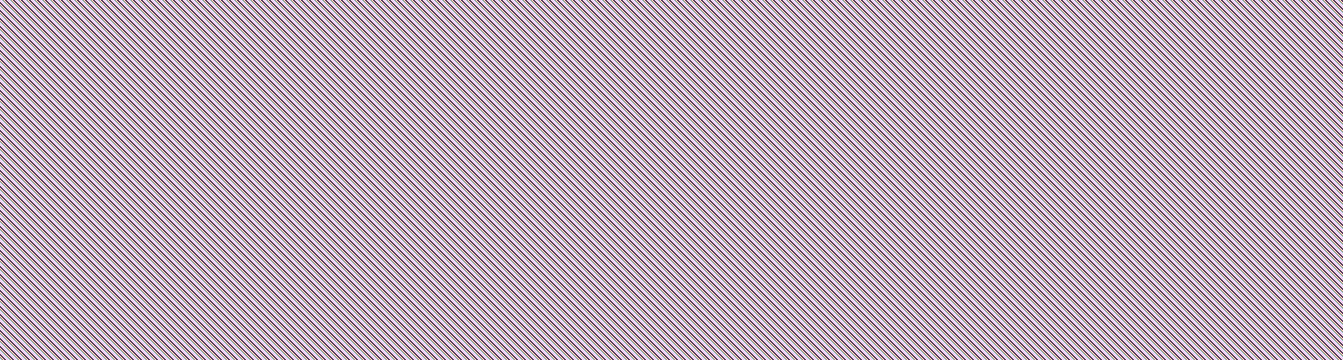

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.06299261748790741
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


<Figure size 1800x216 with 0 Axes>

In [5]:
plt.figure(figsize=(25, 3))
exp.trainer.validate(model=eval_module, dataloaders=exp.datamodule.val_dataloader());

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

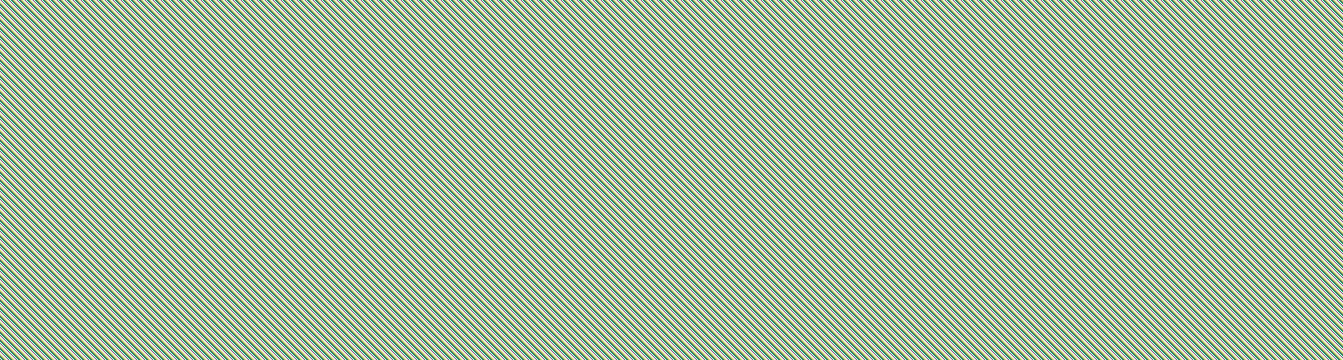

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.09823475033044815
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


<Figure size 1800x216 with 0 Axes>

In [6]:
plt.figure(figsize=(25, 3))
exp.trainer.validate(model=eval_module, dataloaders=exp.datamodule.train_dataloader(shuffle=False)); # Check dataloader is not shuffled

### Compute aggregated metrics

In [7]:
class LitMetricsModule(LitSMCModule):
    def validation_step(self, batch, batch_idx):
        u, y = batch
        y_hat = self.forward(u, y)
        mse = torch.nn.functional.mse_loss(y, y_hat, reduction='none')
        mae = torch.nn.functional.l1_loss(y, y_hat, reduction='none')
        return mse, mae
    def validation_epoch_end(self, outputs):
        mse, mae = map(lambda batches: torch.cat(batches, dim=1), zip(*outputs))
        metrics = {
            "mse": self._compute_cumsum(mse),
            "mae": self._compute_cumsum(mae)
        }
        for idx_plot, (metric_name, metric_values) in enumerate(metrics.items()):
            # plt.subplot(len(metrics), 1, idx_plot+1)
            plt.plot(metric_values.squeeze().cpu().numpy(), label=metric_name)
            plt.legend()
    @staticmethod
    def _compute_cumsum(metric):
        return metric.cumsum(dim=0).mean(dim=1) / torch.arange(1, len(metric)+1, device=metric.device).unsqueeze(-1)
    
eval_module = LitMetricsModule.load_from_checkpoint(args.load_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

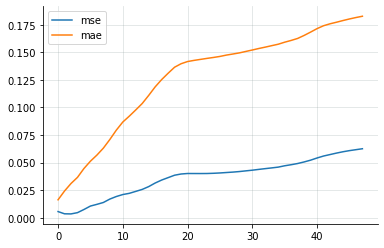

In [8]:
exp.trainer.validate(model=eval_module, dataloaders=exp.datamodule.val_dataloader());

### Evaluate on a validation sample

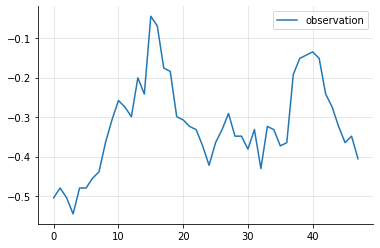

In [9]:
# Load batch
dataloader = exp.datamodule.val_dataloader()
batch_idx = 0
sample_idx = 0
for idx, (commands, observations) in enumerate(dataloader):
    if idx >= batch_idx:
        break

# Plot
plt.plot(observations[:, sample_idx].squeeze().cpu().numpy(), label="observation")
plt.legend()
plt.show()

## Uncertainty evaluations

In [10]:
exp.litmodule.finetune = True

### Smooth

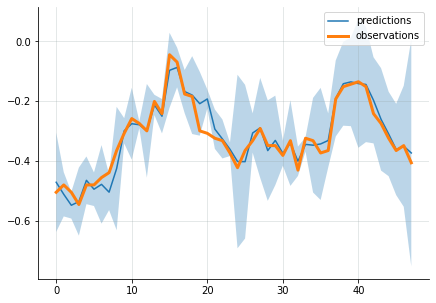

In [11]:
with torch.no_grad():
    netout = exp.litmodule.forward(commands, observations)

netout = exp.litmodule.smcl.smooth_pms(netout, exp.litmodule.smcl.I).numpy()

plt.figure(figsize=(7, 5))
plot_range(netout[:, sample_idx, :, 0], label='predictions')
plt.plot(observations[:, sample_idx, 0], lw=3, label='observations')
plt.legend()
plt.show()

### Predict at $t+1$

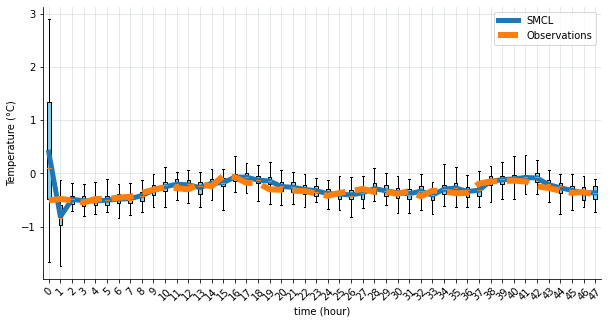

In [12]:
plt.figure(figsize=(10, 5))
predictions = predict(exp.litmodule, commands, observations)
plot_particules_prediction(observations, predictions)

### Predict after the first hour

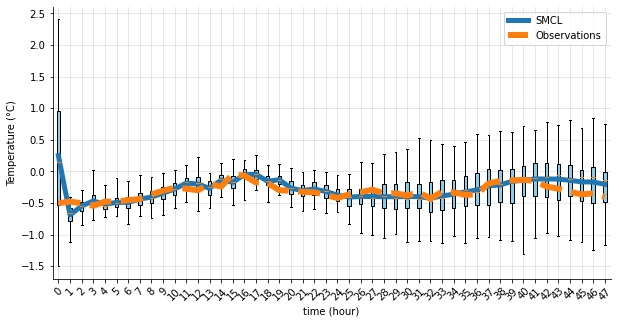

In [13]:
plt.figure(figsize=(10, 5))
predictions = predict(exp.litmodule, commands, observations, hide_start=24)
plot_particules_prediction(observations, predictions)